# 9. Automated Machine Learning 

This notebook contains some basics for autoML using CapyMOA:

* Implement a custom model selection procedure using CapyMOA.
* Perform hyperparameter optimization, and model selection using CapyMOA's AutoML
  features.

---

In [1]:
# This cell is hidden on capymoa.org. See docs/contributing/docs.rst
from util.nbmock import mock_datasets, is_nb_fast

if is_nb_fast():
    mock_datasets()

In [2]:
from capymoa.datasets import Electricity
from capymoa.evaluation import prequential_evaluation
from moa.streams import ConceptDriftStream
from capymoa.stream.drift import DriftStream
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.classifier import (
    HoeffdingTree,
    HoeffdingAdaptiveTree,
    KNN,
    NaiveBayes,
    AdaptiveRandomForestClassifier,
    StreamingRandomPatches,
)

# Setup the data streams for our experiments:
stream = Electricity()
drift_stream = DriftStream(
    moa_stream=ConceptDriftStream(),
    CLI="""
    -s (generators.AgrawalGenerator -f 1) 
    -d (ConceptDriftStream 
        -s (generators.AgrawalGenerator -f 2)
        -d (ConceptDriftStream -s (generators.AgrawalGenerator -f 3) 
        -d (generators.AgrawalGenerator -f 4) -p 30000 -w 0)
        -p 20000 -w 0) 
    -p 10000 
    -w 0
""",
)

In [3]:
def print_summary(label: str, results):
    print(
        f"{label.ljust(10)} Cumulative accuracy = {results.accuracy():.2f}, "
        f"wall-clock time: {results.wallclock():.3f}"
    )

## 9.1 Custom Model Selection

In this section we manually define a method to select the best model based on
its accuracy on a given stream. First we define a list of models to be tried
and then we iterate over the stream to train and evaluate each model. The
model with the highest accuracy is selected as the best model.

In [4]:
# Define a generic adaptive learning function
def stream_learning_model_selection(model_list, window_size, max_instances):
    best_accuracy = 0  # The best accuracy score
    all_results = {}
    for model in model_list:
        results = prequential_evaluation(
            stream=stream,
            learner=model,
            window_size=window_size,
            max_instances=max_instances,
        )
        all_results[model] = results
        if results.cumulative.accuracy() > best_accuracy:
            best_accuracy = results.cumulative.accuracy()
            model_b = model

    print_summary(f"Best ({model_b})", all_results[model_b])
    return all_results

Best (StreamingRandomPatches) Cumulative accuracy = 90.56, wall-clock time: 0.404


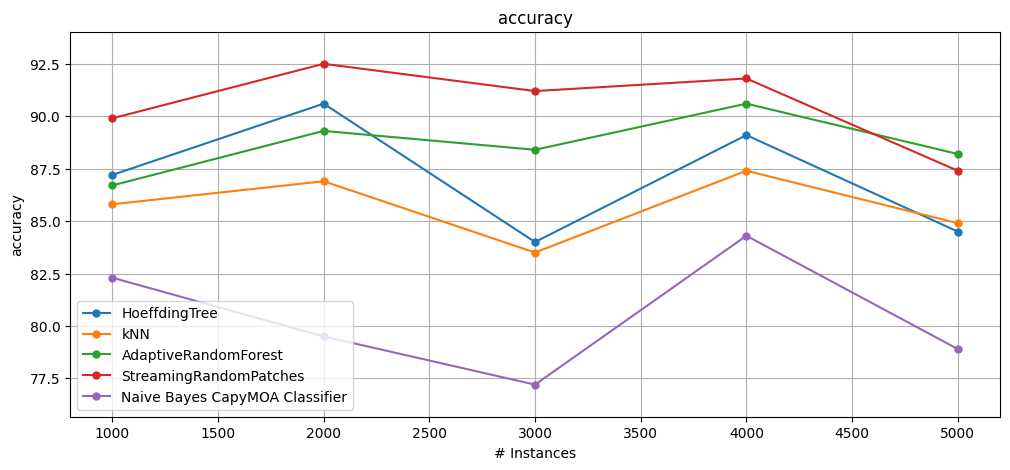

In [5]:
# Code to select the best performing model
schema = stream.get_schema()
ht = HoeffdingTree(schema)
knn = KNN(schema)
arf = AdaptiveRandomForestClassifier(schema, ensemble_size=5)
srp = StreamingRandomPatches(schema, ensemble_size=5)
nb = NaiveBayes(schema)
model_list = [ht, knn, arf, srp, nb]

all_res = stream_learning_model_selection(model_list, 1000, 5000)
plot_windowed_results(*all_res.values(), metric="accuracy")

## 9.2 AutoML

The following example shows how to use the AutoClass algorithm using CapyMOA.

* ``base_classifiers`` is a list of classifier class types that will be candidates
  for the AutoML algorithm. The AutoML algorithm will select the best classifier
  based on its performance on the stream.

* ``configuration_json`` is a json file that contains the configuration for the
  AutoML algorithm. An example of the configuration file is shown below:


*Maroua Bahri, Nikolaos Georgantas. Autoclass: Automl for data stream
classification. In BigData, IEEE, 2023. https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10386362*

In [6]:
with open("./settings_autoclass.json", "r") as f:
    settings = f.read()
    print(settings)

{

  "windowSize" :  1000,
  "ensembleSize" : 10,
  "newConfigurations" : 10,
  "keepCurrentModel" : true,
  "lambda" : 0.05,
  "preventAlgorithmDeath" : true,
  "keepGlobalIncumbent" : true,
  "keepAlgorithmIncumbents" : true,
  "keepInitialConfigurations" : true,
  "useTestEnsemble" : true,
  "resetProbability" : 0.01,
  "numberOfCores" : 1,
  "performanceMeasureMaximisation": true,

  "algorithms": [
    {
      "algorithm": "moa.classifiers.lazy.kNN",
      "parameters": [
        {"parameter": "k", "type":"integer", "value":10, "range":[2,30]}
      ]
    }
  ,
    {
      "algorithm": "moa.classifiers.trees.HoeffdingTree",
      "parameters": [
        {"parameter": "g", "type":"integer", "value":200, "range":[10, 200]},
       {"parameter": "c", "type":"float", "value":0.01, "range":[0, 1]}
      ]
    }
  ,
    {
      "algorithm": "moa.classifiers.lazy.kNNwithPAWandADWIN",
      "parameters": [
        {"parameter": "k", "type":"integer", "value":10, "range":[2,30]}
      ]
  

In [7]:
from capymoa.automl import AutoClass

max_instances = 20000
window_size = 2500

schema = stream.get_schema()
autoclass = AutoClass(
    schema=schema,
    configuration_json="./settings_autoclass.json",
    base_classifiers=[KNN, HoeffdingAdaptiveTree, HoeffdingTree],
)
results_autoclass = prequential_evaluation(
    stream=stream,
    learner=autoclass,
    window_size=window_size,
    max_instances=max_instances,
)
print_summary("AutoClass", results_autoclass)

AutoClass  Cumulative accuracy = 88.52, wall-clock time: 23.960


We compare the performance of the AutoML algorithm against basic
classifiers:

HT         Cumulative accuracy = 85.61, wall-clock time: 0.094
HAT        Cumulative accuracy = 87.08, wall-clock time: 0.134
KNN        Cumulative accuracy = 85.47, wall-clock time: 1.422
NB         Cumulative accuracy = 77.23, wall-clock time: 0.050


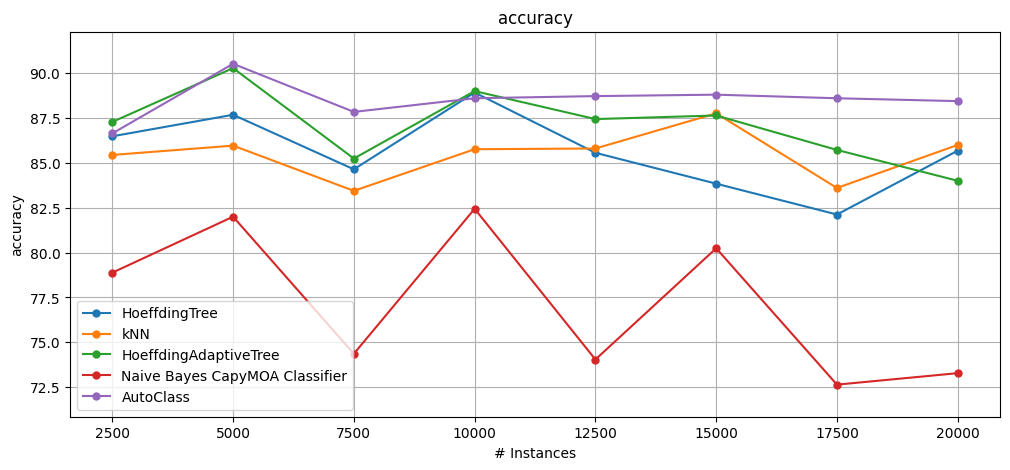

In [8]:
ht = HoeffdingTree(schema)
hat = HoeffdingAdaptiveTree(schema)
knn = KNN(schema)
nb = NaiveBayes(schema)

results_ht = prequential_evaluation(
    stream, ht, window_size=window_size, max_instances=max_instances
)
results_hat = prequential_evaluation(
    stream, hat, window_size=window_size, max_instances=max_instances
)
results_knn = prequential_evaluation(
    stream, knn, window_size=window_size, max_instances=max_instances
)
results_nb = prequential_evaluation(
    stream, nb, window_size=window_size, max_instances=max_instances
)

print_summary("HT", results_ht)
print_summary("HAT", results_hat)
print_summary("KNN", results_knn)
print_summary("NB", results_nb)
plot_windowed_results(
    results_ht,
    results_knn,
    results_hat,
    results_nb,
    results_autoclass,
    metric="accuracy",
)

## 9.3 AutoML with Concept Drift

We test the same algorithms on a data stream with simulated concept drift:

HT         Cumulative accuracy = 78.82, wall-clock time: 0.198
HAT        Cumulative accuracy = 78.24, wall-clock time: 0.174
KNN        Cumulative accuracy = 67.14, wall-clock time: 4.366
NB         Cumulative accuracy = 60.29, wall-clock time: 0.055
AutoClass  Cumulative accuracy = 84.84, wall-clock time: 60.880


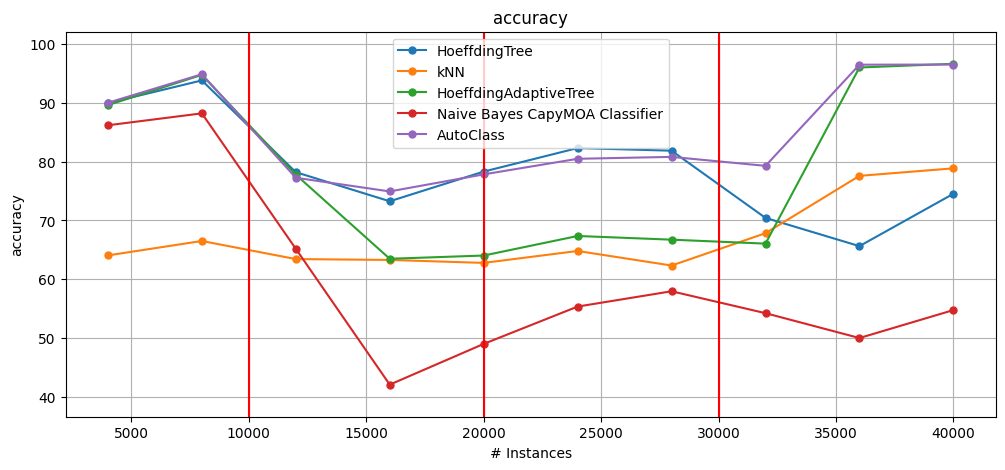

In [9]:
from capymoa.evaluation import prequential_evaluation
from capymoa.automl import AutoClass

max_instances = 40000
window_size = 4000

ht = HoeffdingTree(schema=drift_stream.get_schema())
hat = HoeffdingAdaptiveTree(schema=drift_stream.get_schema())
knn = KNN(schema=drift_stream.get_schema())
nb = NaiveBayes(schema=drift_stream.get_schema())
autoclass = AutoClass(
    schema=drift_stream.get_schema(),
    configuration_json="./settings_autoclass.json",
    base_classifiers=[KNN, HoeffdingAdaptiveTree, HoeffdingTree],
)

results_ht = prequential_evaluation(
    drift_stream, ht, window_size=window_size, max_instances=max_instances
)
results_hat = prequential_evaluation(
    drift_stream, hat, window_size=window_size, max_instances=max_instances
)
results_knn = prequential_evaluation(
    drift_stream, knn, window_size=window_size, max_instances=max_instances
)
results_nb = prequential_evaluation(
    drift_stream, nb, window_size=window_size, max_instances=max_instances
)
results_autoclass = prequential_evaluation(
    drift_stream, autoclass, window_size=window_size, max_instances=max_instances
)

print_summary("HT", results_ht)
print_summary("HAT", results_hat)
print_summary("KNN", results_knn)
print_summary("NB", results_nb)
print_summary("AutoClass", results_autoclass)
plot_windowed_results(
    results_ht,
    results_knn,
    results_hat,
    results_nb,
    results_autoclass,
    metric="accuracy",
)